In [1]:
# Imports
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")

pd.set_option('display.max_columns', None)


Using device: cpu


In [2]:
# Load the dataset
dataset = pd.read_csv("dataset.csv")
dataset.head()


,MMM_TIMESERIES_ID,ORGANISATION_ID,ORGANISATION_VERTICAL,ORGANISATION_SUBVERTICAL,ORGANISATION_MARKETING_SOURCES,ORGANISATION_PRIMARY_TERRITORY_NAME,TERRITORY_NAME,DATE_DAY,CURRENCY_CODE,FIRST_PURCHASES,FIRST_PURCHASES_UNITS,FIRST_PURCHASES_ORIGINAL_PRICE,FIRST_PURCHASES_GROSS_DISCOUNT,ALL_PURCHASES,ALL_PURCHASES_UNITS,ALL_PURCHASES_ORIGINAL_PRICE,ALL_PURCHASES_GROSS_DISCOUNT,GOOGLE_PAID_SEARCH_SPEND,GOOGLE_SHOPPING_SPEND,GOOGLE_PMAX_SPEND,GOOGLE_DISPLAY_SPEND,GOOGLE_VIDEO_SPEND,META_FACEBOOK_SPEND,META_INSTAGRAM_SPEND,META_OTHER_SPEND,TIKTOK_SPEND,GOOGLE_PAID_SEARCH_CLICKS,GOOGLE_SHOPPING_CLICKS,GOOGLE_PMAX_CLICKS,GOOGLE_DISPLAY_CLICKS,GOOGLE_VIDEO_CLICKS,META_FACEBOOK_CLICKS,META_INSTAGRAM_CLICKS,META_OTHER_CLICKS,TIKTOK_CLICKS,GOOGLE_PAID_SEARCH_IMPRESSIONS,GOOGLE_SHOPPING_IMPRESSIONS,GOOGLE_PMAX_IMPRESSIONS,GOOGLE_DISPLAY_IMPRESSIONS,GOOGLE_VIDEO_IMPRESSIONS,META_FACEBOOK_IMPRESSIONS,META_INSTAGRAM_IMPRESSIONS,META_OTHER_IMPRESSIONS,TIKTOK_IMPRESSIONS,DIRECT_CLICKS,BRANDED_SEARCH_CLICKS,ORGANIC_SEARCH_CLICKS,EMAIL_CLICKS,REFERRAL_CLICKS,ALL_OTHER_CLICKS
0,596eef7c71f933d820d0e485935d0e8f,04769dac8b828ec7a85676d9e2bffe6f,Beauty & Fitness,Hair Care,"Google, Meta",US,All Territories,2022-07-29,USD,22,27,3837.980834,632.595555,27,32,4552.984240,846.593069,NaN,NaN,205.528905,NaN,NaN,233.75,NaN,NaN,NaN,NaN,NaN,255.0,NaN,NaN,163.0,NaN,NaN,NaN,NaN,NaN,31907.0,NaN,NaN,18997.0,NaN,NaN,NaN,139.0,NaN,300.0,1.0,61.0,40.0
1,596eef7c71f933d820d0e485935d0e8f,04769dac8b828ec7a85676d9e2bffe6f,Beauty & Fitness,Hair Care,"Google, Meta",US,All Territories,2022-07-30,USD,14,21,2747.998631,443.996522,17,26,3177.998032,613.806522,NaN,NaN,277.082025,NaN,NaN,248.84,NaN,NaN,NaN,NaN,NaN,348.0,NaN,NaN,128.0,NaN,NaN,NaN,NaN,NaN,44483.0,NaN,NaN,20188.0,NaN,NaN,NaN,209.0,NaN,442.0,8.0,110.0,62.0
2,596eef7c71f933d820d0e485935d0e8f,04769dac8b828ec7a85676d9e2bffe6f,Beauty & Fitness,Hair Care,"Google, Meta",US,All Territories,2022-07-31,USD,31,39,4567.998818,1185.197966,39,48,5468.998818,1504.997966,NaN,NaN,427.436429,NaN,NaN,274.51,NaN,NaN,NaN,NaN,NaN,405.0,NaN,NaN,148.0,NaN,NaN,NaN,NaN,NaN,58173.0,NaN,NaN,24718.0,NaN,NaN,NaN,262.0,NaN,427.0,631.0,108.0,65.0
3,596eef7c71f933d820d0e485935d0e8f,04769dac8b828ec7a85676d9e2bffe6f,Beauty & Fitness,Hair Care,"Google, Meta",US,All Territories,2022-08-01,USD,18,30,2878.982385,696.519993,22,34,3335.970202,754.410747,35.24,NaN,347.232798,NaN,NaN,270.06,NaN,NaN,NaN,48.0,NaN,320.0,NaN,NaN,163.0,NaN,NaN,NaN,890.0,NaN,55559.0,NaN,NaN,25076.0,NaN,NaN,NaN,247.0,NaN,400.0,117.0,125.0,68.0
4,596eef7c71f933d820d0e485935d0e8f,04769dac8b828ec7a85676d9e2bffe6f,Beauty & Fitness,Hair Care,"Google, Meta",US,All Territories,2022-08-02,USD,23,27,3107.993669,627.097427,28,33,3991.987441,934.011083,38.40,NaN,314.952971,NaN,NaN,257.62,NaN,NaN,NaN,46.0,NaN,330.0,NaN,NaN,127.0,NaN,NaN,NaN,702.0,NaN,47854.0,NaN,NaN,22688.0,NaN,NaN,NaN,255.0,NaN,425.0,37.0,146.0,65.0


In [3]:
# Define columns to impute
columns_to_impute = [
    # Google spend
    'GOOGLE_PAID_SEARCH_SPEND','GOOGLE_SHOPPING_SPEND','GOOGLE_PMAX_SPEND','GOOGLE_DISPLAY_SPEND','GOOGLE_VIDEO_SPEND',
    # Google impressions
    'GOOGLE_PAID_SEARCH_IMPRESSIONS','GOOGLE_SHOPPING_IMPRESSIONS','GOOGLE_PMAX_IMPRESSIONS','GOOGLE_DISPLAY_IMPRESSIONS','GOOGLE_VIDEO_IMPRESSIONS',
    # Google clicks
    'GOOGLE_PAID_SEARCH_CLICKS','GOOGLE_SHOPPING_CLICKS','GOOGLE_PMAX_CLICKS','GOOGLE_DISPLAY_CLICKS','GOOGLE_VIDEO_CLICKS',
    # Meta spend
    'META_FACEBOOK_SPEND','META_INSTAGRAM_SPEND','META_OTHER_SPEND',
    # Meta impressions
    'META_FACEBOOK_IMPRESSIONS','META_INSTAGRAM_IMPRESSIONS','META_OTHER_IMPRESSIONS',
    # Meta clicks
    'META_FACEBOOK_CLICKS','META_INSTAGRAM_CLICKS','META_OTHER_CLICKS',
    # TikTok
    'TIKTOK_SPEND','TIKTOK_IMPRESSIONS','TIKTOK_CLICKS',
    # Other clicks
    'DIRECT_CLICKS','BRANDED_SEARCH_CLICKS','ORGANIC_SEARCH_CLICKS','EMAIL_CLICKS','REFERRAL_CLICKS','ALL_OTHER_CLICKS'
]

# Create a copy and fill NaNs with 0
dataset_imputed = dataset.copy()
dataset_imputed[columns_to_impute] = dataset_imputed[columns_to_impute].fillna(0)


In [4]:
# Feature Engineering - Create derived features
new_dataset = dataset_imputed.copy()

# Click columns
click_columns = ['GOOGLE_PAID_SEARCH_CLICKS','GOOGLE_SHOPPING_CLICKS','GOOGLE_PMAX_CLICKS','GOOGLE_DISPLAY_CLICKS','GOOGLE_VIDEO_CLICKS',
                'META_FACEBOOK_CLICKS','META_INSTAGRAM_CLICKS','META_OTHER_CLICKS','TIKTOK_CLICKS',
                'DIRECT_CLICKS','BRANDED_SEARCH_CLICKS','ORGANIC_SEARCH_CLICKS','EMAIL_CLICKS','REFERRAL_CLICKS','ALL_OTHER_CLICKS']

# Adding total clicks
new_dataset['TOTAL_CLICKS'] = new_dataset[click_columns].sum(axis=1)

# Impression columns
impression_columns = ['GOOGLE_PAID_SEARCH_IMPRESSIONS','GOOGLE_SHOPPING_IMPRESSIONS','GOOGLE_PMAX_IMPRESSIONS','GOOGLE_DISPLAY_IMPRESSIONS','GOOGLE_VIDEO_IMPRESSIONS',
                      'META_FACEBOOK_IMPRESSIONS','META_INSTAGRAM_IMPRESSIONS','META_OTHER_IMPRESSIONS',
                      'TIKTOK_IMPRESSIONS']

# Adding total impressions
new_dataset['TOTAL_IMPRESSIONS'] = new_dataset[impression_columns].sum(axis=1)

# Spend columns
spend_columns = ['GOOGLE_PAID_SEARCH_SPEND','GOOGLE_SHOPPING_SPEND','GOOGLE_PMAX_SPEND','GOOGLE_DISPLAY_SPEND','GOOGLE_VIDEO_SPEND',
                'META_FACEBOOK_SPEND','META_INSTAGRAM_SPEND','META_OTHER_SPEND',
                'TIKTOK_SPEND']

# Adding total spend
new_dataset['TOTAL_SPEND'] = new_dataset[spend_columns].sum(axis=1)

# Create target variables - ROI metrics
new_dataset["ROI"] = new_dataset["ALL_PURCHASES"] / new_dataset["TOTAL_SPEND"]
new_dataset["ROI_RETURNING"] = (new_dataset["ALL_PURCHASES"] - new_dataset["FIRST_PURCHASES"]) / new_dataset["TOTAL_SPEND"]
new_dataset["ROI_FIRST"] = new_dataset["FIRST_PURCHASES"] / new_dataset["TOTAL_SPEND"]
new_dataset["CTR"] = new_dataset["TOTAL_CLICKS"] / new_dataset["TOTAL_IMPRESSIONS"]
new_dataset["CP_DOLLAR"] = new_dataset["TOTAL_SPEND"] / new_dataset["TOTAL_CLICKS"]

# Replace infinity values with NaN and then fill with 0
new_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
new_dataset.fillna(0, inplace=True)


In [5]:
# Remove outliers (following eda.ipynb approach)
target_variables = ['ROI_FIRST', 'ROI', 'ROI_RETURNING', 'CTR', 'CP_DOLLAR']

# Calculate 0.5th and 99.5th percentiles for each target variable
lower_percentile = new_dataset[target_variables].quantile(0.005)
upper_percentile = new_dataset[target_variables].quantile(0.995)

# Filter out outliers - keep rows where ALL target variables are within bounds
mask = True
for var in target_variables:
    mask = mask & (new_dataset[var] >= lower_percentile[var]) & (new_dataset[var] <= upper_percentile[var]) & (new_dataset[var] != 0)

new_dataset = new_dataset[mask]


In [6]:
# Prepare dataset for modeling - Drop columns that leak information about targets
model_dataset = new_dataset.copy()

# Drop original target variable columns
model_dataset = model_dataset.drop(columns=['FIRST_PURCHASES', 'ALL_PURCHASES'])

# Drop columns that would give away information about the target variable
# We keep impressions and spend as they're known before the campaign
model_dataset = model_dataset.drop(columns=click_columns)

# Remove purchase outcome columns
purchase_outcome_columns = ['FIRST_PURCHASES_UNITS', 'FIRST_PURCHASES_ORIGINAL_PRICE', 'FIRST_PURCHASES_GROSS_DISCOUNT',
                            'ALL_PURCHASES_UNITS', 'ALL_PURCHASES_ORIGINAL_PRICE', 'ALL_PURCHASES_GROSS_DISCOUNT',
                            'TOTAL_CLICKS']
model_dataset = model_dataset.drop(columns=purchase_outcome_columns)


In [7]:
# Handle categorical variables - encode string columns
categorical_columns = ['ORGANISATION_VERTICAL', 'ORGANISATION_SUBVERTICAL', 'ORGANISATION_MARKETING_SOURCES', 
                       'ORGANISATION_PRIMARY_TERRITORY_NAME', 'TERRITORY_NAME', 'CURRENCY_CODE']

# Label encode categorical variables
label_encoders = {}
for col in categorical_columns:
    if col in model_dataset.columns:
        le = LabelEncoder()
        # Fill NaN values and convert all values to strings to ensure uniform type
        model_dataset[col] = model_dataset[col].fillna('Unknown').astype(str)
        model_dataset[col] = le.fit_transform(model_dataset[col])
        label_encoders[col] = le

# Drop ID columns and date as they don't provide predictive value
columns_to_drop = ['MMM_TIMESERIES_ID', 'ORGANISATION_ID', 'DATE_DAY']
for col in columns_to_drop:
    if col in model_dataset.columns:
        model_dataset = model_dataset.drop(columns=[col])

In [8]:
# Use the full dataset without sampling
# Separate features and targets
X = model_dataset.drop(columns=target_variables)
y = model_dataset[target_variables]

# Split into train and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
# Standardize features (important for neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors and move to device
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)

# Store target scalers for each target variable (helps with training stability)
target_scalers = {}
y_train_scaled_dict = {}
y_test_scaled_dict = {}

for target in target_variables:
    target_scaler = StandardScaler()
    y_train_scaled_dict[target] = target_scaler.fit_transform(y_train[[target]])
    y_test_scaled_dict[target] = target_scaler.transform(y_test[[target]])
    target_scalers[target] = target_scaler


In [10]:
# Define Flexible Neural Network Architecture with configurable activation functions and layer sizes
class MarketingROIModel(nn.Module):
    def __init__(self, input_dim, layer_sizes, activation_fn, dropout_rates):
        super(MarketingROIModel, self).__init__()
        
        # Map activation function names to PyTorch modules
        activation_map = {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid(),
            'elu': nn.ELU(),
            'leaky_relu': nn.LeakyReLU(0.01)
        }
        
        self.activation = activation_map.get(activation_fn.lower(), nn.ReLU())
        self.layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        # Build layers
        prev_size = input_dim
        for i, layer_size in enumerate(layer_sizes):
            self.layers.append(nn.Linear(prev_size, layer_size))
            if i < len(dropout_rates):
                self.dropouts.append(nn.Dropout(dropout_rates[i]))
            prev_size = layer_size
        
        # Output layer
        self.output = nn.Linear(prev_size, 1)
        
    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            x = self.activation(x)
            if i < len(self.dropouts):
                x = self.dropouts[i](x)
        x = self.output(x)
        return x


In [11]:
# Training function with configurable loss function, Adam optimizer, and learning rate scheduling
def train_model(model, X_train, y_train, X_test, y_test, epochs=20, learning_rate=0.01, 
                loss_fn='mse', batch_size=64, verbose=False):
    # Create DataLoader for batch training
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    # Map loss function names to PyTorch loss functions
    loss_map = {
        'mse': nn.MSELoss(),
        'mae': nn.L1Loss(),
        'huber': nn.HuberLoss(delta=1.0)
    }
    criterion = loss_map.get(loss_fn.lower(), nn.MSELoss())
    
    # Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Learning rate scheduler - exponential decay for finding local optima
    # Starts high (exploration) and decays to low (fine-tuning)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    # Track history
    history = {
        'train_loss': [],
        'test_loss': [],
        'learning_rate': []
    }
    
    # Training loop
    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Get current learning rate
        current_lr = optimizer.param_groups[0]['lr']
        
        # Evaluation phase
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test).item()
        
        history['train_loss'].append(train_loss)
        history['test_loss'].append(test_loss)
        history['learning_rate'].append(current_lr)
        
        # Step the scheduler after each epoch
        scheduler.step()
        
        # Print progress if verbose
        if verbose and (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}, LR: {current_lr:.6f}')
    
    return history


In [12]:
activation_functions = ['relu', 'leaky_relu'] 
loss_functions = ['mse']
learning_rate_initial = 0.01
holdout_rates = [0.2]
layer_configs = [
    [64, 32],
    [128, 64, 32],
    [256, 128, 64],
    [128, 64, 32, 16],
]

# Dropout rates (matching layer count)
dropout_configs = [
    [0.3, 0.2],
    [0.3, 0.2, 0.1],
    [0.3, 0.2, 0.1],
    [0.3, 0.2, 0.1, 0.1],
]

In [13]:
# Prepare data for ROI model only
target = 'ROI'

X_full = model_dataset.drop(columns=target_variables)
y_full = model_dataset[target]


In [14]:
# Hyperparameter Search - Train models with different configurations
results = []
model_count = 0
total_combinations = len(activation_functions) * len(loss_functions) * len(holdout_rates) * len(layer_configs)

for activation_fn in activation_functions:
    for loss_fn in loss_functions:
        for test_size in holdout_rates:
            for layer_idx, layer_sizes in enumerate(layer_configs):
                model_count += 1
                
                # Create train/test split with current holdout rate (using UNSCALED data)
                X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
                    X_full, y_full.values.reshape(-1, 1), test_size=test_size, random_state=42
                )
                
                # Standardize features for this split (fit on train, transform both)
                scaler_split = StandardScaler()
                X_train_split_scaled = scaler_split.fit_transform(X_train_split)
                X_test_split_scaled = scaler_split.transform(X_test_split)
                
                # Standardize target for this split (fit on train, transform both)
                target_scaler_split = StandardScaler()
                y_train_split_scaled = target_scaler_split.fit_transform(y_train_split)
                y_test_split_scaled = target_scaler_split.transform(y_test_split)
                
                # Convert to PyTorch tensors
                X_train_t = torch.FloatTensor(X_train_split_scaled).to(device)
                X_test_t = torch.FloatTensor(X_test_split_scaled).to(device)
                y_train_t = torch.FloatTensor(y_train_split_scaled).to(device)
                y_test_t = torch.FloatTensor(y_test_split_scaled).to(device)
                
                # Get dropout rates for this layer configuration
                dropout_rates = dropout_configs[layer_idx]
                
                # Create model
                input_dim = X_train_t.shape[1]
                model = MarketingROIModel(input_dim, layer_sizes, activation_fn, dropout_rates).to(device)
                
                # Train model with learning rate scheduler
                history = train_model(
                    model, X_train_t, y_train_t, X_test_t, y_test_t,
                    epochs=20, learning_rate=learning_rate_initial, loss_fn=loss_fn, batch_size=64, verbose=False
                )
                
                # Evaluate model
                model.eval()
                with torch.no_grad():
                    y_pred_scaled = model(X_test_t).cpu().numpy()
                
                # Inverse transform to original scale
                y_pred = target_scaler_split.inverse_transform(y_pred_scaled)
                y_actual = target_scaler_split.inverse_transform(y_test_split_scaled)
                
                # Calculate metrics
                mse = mean_squared_error(y_actual, y_pred)
                rmse = np.sqrt(mse)
                r2 = r2_score(y_actual, y_pred)
                
                # Store results
                result = {
                    'model_id': model_count,
                    'activation': activation_fn,
                    'loss_function': loss_fn,
                    'initial_learning_rate': learning_rate_initial,
                    'final_learning_rate': history['learning_rate'][-1],
                    'holdout_rate': test_size,
                    'layer_sizes': str(layer_sizes),
                    'num_layers': len(layer_sizes),
                    'dropout_rates': str(dropout_rates),
                    'final_train_loss': history['train_loss'][-1],
                    'final_test_loss': history['test_loss'][-1],
                    'mse': mse,
                    'rmse': rmse,
                    'r2': r2,
                    'history': history
                }
                results.append(result)
                
                # Print progress after each model
                print(f"Model {model_count}/{total_combinations}: {activation_fn}, {str(layer_sizes):25s} → R²={r2}, RMSE={rmse}")


Model 1/8: relu, [64, 32]                  → R²=0.42922914661288114, RMSE=0.24837251533324287
Model 2/8: relu, [128, 64, 32]             → R²=0.4034740434851918, RMSE=0.2539143902624108
Model 3/8: relu, [256, 128, 64]            → R²=0.4145423562761291, RMSE=0.2515477180985198
Model 4/8: relu, [128, 64, 32, 16]         → R²=0.3876699213313187, RMSE=0.25725595600127693
Model 5/8: leaky_relu, [64, 32]                  → R²=0.49160099543414626, RMSE=0.23440938071605533
Model 6/8: leaky_relu, [128, 64, 32]             → R²=0.43887719353829746, RMSE=0.2462643814833608
Model 7/8: leaky_relu, [256, 128, 64]            → R²=0.4535578922061053, RMSE=0.24302151317789072
Model 8/8: leaky_relu, [128, 64, 32, 16]         → R²=0.37200435637896023, RMSE=0.26052593144138564


In [15]:
# Create results DataFrame and display top models
results_df = pd.DataFrame(results)

# Sort by R² score (descending)
results_df_sorted = results_df.sort_values('r2', ascending=False)

print("Model ID | Activation | Loss | Holdout | Layers | R2 | RMSE | MSE")
# Display top 20
display_cols = ['model_id', 'activation', 'loss_function', 'holdout_rate', 
                'layer_sizes', 'r2', 'rmse', 'mse']

# Print results
print(results_df_sorted[display_cols].head(20).to_string(index=False))
print(f"Best R2:  {results_df['r2'].max()}")
print(f"Best RMSE:  {results_df['rmse'].min()}")


Model ID | Activation | Loss | Holdout | Layers | R2 | RMSE | MSE
 model_id activation loss_function  holdout_rate       layer_sizes       r2     rmse      mse
        5 leaky_relu           mse           0.2          [64, 32] 0.491601 0.234409 0.054948
        7 leaky_relu           mse           0.2    [256, 128, 64] 0.453558 0.243022 0.059059
        6 leaky_relu           mse           0.2     [128, 64, 32] 0.438877 0.246264 0.060646
        1       relu           mse           0.2          [64, 32] 0.429229 0.248373 0.061689
        3       relu           mse           0.2    [256, 128, 64] 0.414542 0.251548 0.063276
        2       relu           mse           0.2     [128, 64, 32] 0.403474 0.253914 0.064473
        4       relu           mse           0.2 [128, 64, 32, 16] 0.387670 0.257256 0.066181
        8 leaky_relu           mse           0.2 [128, 64, 32, 16] 0.372004 0.260526 0.067874
Best R2:  0.49160099543414626
Best RMSE:  0.23440938071605533


In [16]:
# Best activation function
best_by_activation = results_df.groupby('activation')['r2'].mean().sort_values(ascending=False)
print(f"\nBest Activation Functions (by mean R2):")
for act, score in best_by_activation.items():
    print(f"{act}: {score}")

# Best loss function
best_by_loss = results_df.groupby('loss_function')['r2'].mean().sort_values(ascending=False)
print(f"\nBest Loss Functions (by mean R2):")
for loss, score in best_by_loss.items():
    print(f"{loss}: {score}")

# Best holdout rate
best_by_holdout = results_df.groupby('holdout_rate')['r2'].mean().sort_values(ascending=False)
print(f"\nBest Holdout Rates (by mean R2):")
for hr, score in best_by_holdout.items():
    print(f"{hr}: {score}")

# Best layer configuration
best_by_layers = results_df.groupby('layer_sizes')['r2'].mean().sort_values(ascending=False)
print(f"\nBest Layer Configurations (by mean R2):")
for layers, score in best_by_layers.items():
    print(f"{layers}: {score}")



Best Activation Functions (by mean R2):
leaky_relu: 0.43901010938937735
relu: 0.4087288669263802

Best Loss Functions (by mean R2):
mse: 0.4238694881578787

Best Holdout Rates (by mean R2):
0.2: 0.4238694881578787

Best Layer Configurations (by mean R2):
[64, 32]: 0.4604150710235137
[256, 128, 64]: 0.4340501242411172
[128, 64, 32]: 0.4211756185117446
[128, 64, 32, 16]: 0.3798371388551395


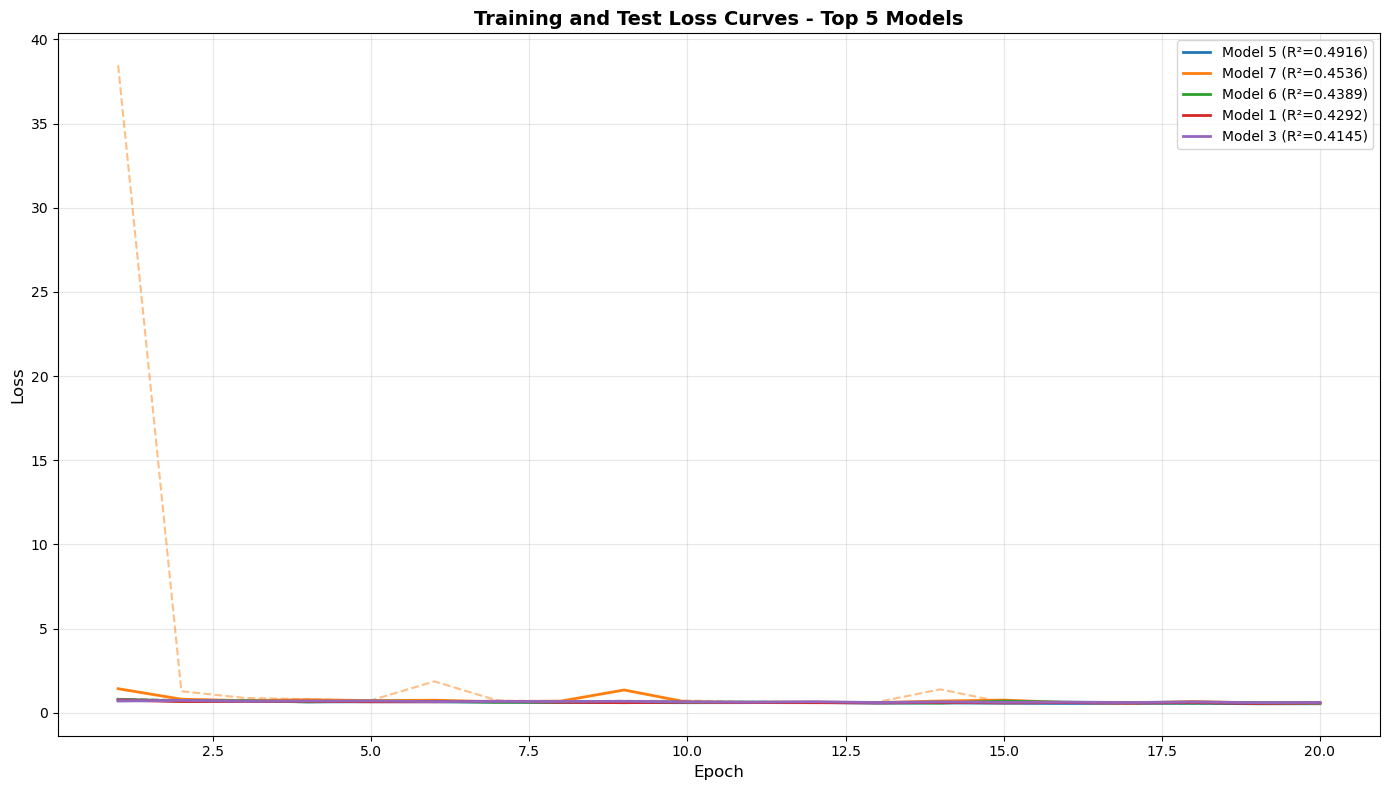

In [18]:
fig, axes = plt.subplots(1, 1, figsize=(14, 8))

top_5 = results_df_sorted.head(5)
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for idx, (_, row) in enumerate(top_5.iterrows()):
    history = row['history']
    epochs = range(1, len(history['test_loss']) + 1)
    label = f"Model {row['model_id']} (R²={row['r2']:.4f})"
    axes.plot(epochs, history['test_loss'], label=label, linewidth=2, color=colors[idx])
    axes.plot(epochs, history['train_loss'], '--', linewidth=1.5, color=colors[idx], alpha=0.5)

axes.set_xlabel('Epoch', fontsize=12)
axes.set_ylabel('Loss', fontsize=12)
axes.set_title('Training and Test Loss Curves - Top 5 Models', fontsize=14, fontweight='bold')
axes.legend(fontsize=10)
axes.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


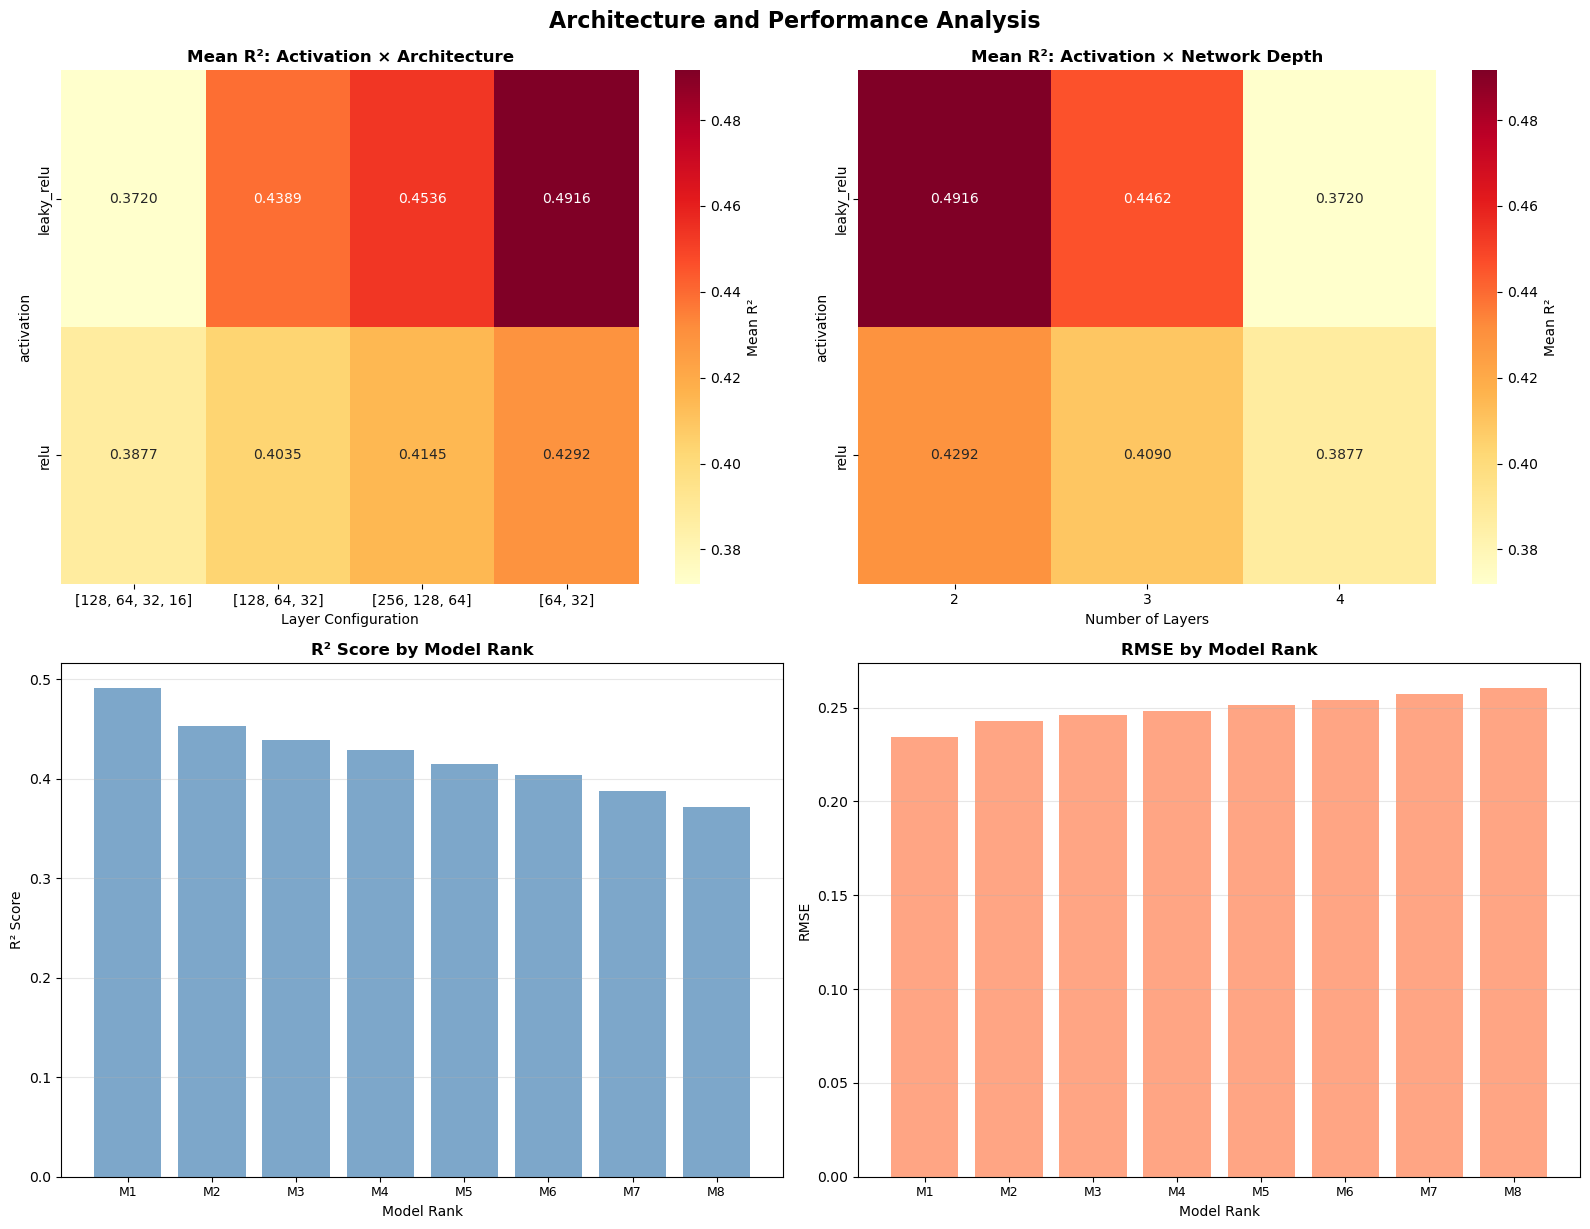

In [19]:
# 4. Architecture and Performance Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Activation vs Layer Configuration
pivot1 = results_df.pivot_table(values='r2', index='activation', columns='layer_sizes', aggfunc='mean')
sns.heatmap(pivot1, annot=True, fmt='.4f', cmap='YlOrRd', ax=axes[0,0], cbar_kws={'label': 'Mean R²'})
axes[0,0].set_title('Mean R²: Activation × Architecture', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Layer Configuration', fontsize=10)

# Activation vs Number of Layers
pivot2 = results_df.pivot_table(values='r2', index='activation', columns='num_layers', aggfunc='mean')
sns.heatmap(pivot2, annot=True, fmt='.4f', cmap='YlOrRd', ax=axes[0,1], cbar_kws={'label': 'Mean R²'})
axes[0,1].set_title('Mean R²: Activation × Network Depth', fontsize=12, fontweight='bold')
axes[0,1].set_xlabel('Number of Layers', fontsize=10)

# All models comparison - R² and RMSE
x_pos = range(len(results_df_sorted))
axes[1,0].bar(x_pos, results_df_sorted['r2'], color='steelblue', alpha=0.7)
axes[1,0].set_xlabel('Model Rank', fontsize=10)
axes[1,0].set_ylabel('R² Score', fontsize=10)
axes[1,0].set_title('R² Score by Model Rank', fontsize=12, fontweight='bold')
axes[1,0].grid(True, alpha=0.3, axis='y')
axes[1,0].set_xticks(x_pos)
axes[1,0].set_xticklabels([f"M{i+1}" for i in x_pos], fontsize=9)

# RMSE by model
axes[1,1].bar(x_pos, results_df_sorted['rmse'], color='coral', alpha=0.7)
axes[1,1].set_xlabel('Model Rank', fontsize=10)
axes[1,1].set_ylabel('RMSE', fontsize=10)
axes[1,1].set_title('RMSE by Model Rank', fontsize=12, fontweight='bold')
axes[1,1].grid(True, alpha=0.3, axis='y')
axes[1,1].set_xticks(x_pos)
axes[1,1].set_xticklabels([f"M{i+1}" for i in x_pos], fontsize=9)

plt.tight_layout()
plt.suptitle('Architecture and Performance Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.show()
